## load trained model (hg19)

In [15]:
#load trained model
from tkinter import W
from torch_geometric.loader import DataLoader
from matplotlib.backends.backend_pdf import PdfPages
from torch.nn import Sequential, Linear, MultiheadAttention, Sigmoid, ReLU, ELU, LeakyReLU, Softmax
from torch_geometric.nn import MessagePassing, knn_graph
from torch_geometric.utils import to_undirected, batched_negative_sampling, remove_self_loops
import torch.nn.functional as F
from torch_geometric.nn import ResGatedGraphConv, GATv2Conv, GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn import EdgePooling, SAGPooling
from torch_geometric.nn import GCNConv, GAE, VGAE, InnerProductDecoder
from torch_scatter import scatter_mean
from torch_sparse import coalesce
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from matplotlib.backends.backend_pdf import PdfPages
import math
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import numpy
import numpy as np
import pandas
import random
import pandas as pd
import sys 
from generate_graphs_for_GM12878model import HiCDataset

In [17]:
class EdgeConv(MessagePassing):
    def __init__(self, n_heads, in_channels, out_channels):
        super().__init__(aggr='mean') #aggregation.
        self.n_heads = n_heads
        self.head_size = out_channels // n_heads
        self.all_heads = out_channels   
        self.softmax = Softmax(dim=-1)
        self.q = Linear(in_channels * 2, out_channels)
        self.k = Linear(in_channels * 2, out_channels)
        self.v = Linear(in_channels * 2, out_channels)
    def reshape(self, e):
        new_shape = e.size()[:-1] + (self.n_heads, self.head_size)
        e = e.view(*new_shape)
        return e.permute(1, 0, 2)  
    def forward(self, x, edge_index, edge_weight, batch=None):
        #print(f'number of edges: {edge_index.size(1)}')
        return self.propagate(edge_index, x=x, edge_weight=edge_weight, size=None)
    def message(self, x_i, x_j, edge_weight):
        query = self.q(torch.cat([x_i, x_j - x_i], dim=1))
        key = self.k(torch.cat([x_i, x_j - x_i], dim=1))
        value = self.v(torch.cat([x_i, x_j - x_i], dim=1))
        #print(f'values: {value.size()}')
        query = self.reshape(query)
        key = self.reshape(key)
        value = self.reshape(value)
        value = value * edge_weight[:,None]
        #print(f'keys: {key.size()}')
        scores = torch.mul(query, key)
        scores = scores / math.sqrt(self.head_size)
        probs = self.softmax(scores).to(device)  
        context = torch.mul(probs, value)
        context = context.permute(1, 0, 2).contiguous()
        context_shape = context.size()[:-2] + (self.all_heads, )
        context = context.view(*context_shape)
        #print(f'context: {context.size()}')
        return context

class DynamicEdgeConv(EdgeConv):
    def __init__(self, n_heads, in_channels, out_channels, thres=0.5, K=500, cis=8, n_neighbor=6):
        super().__init__(n_heads, in_channels, out_channels)
        self.K = K
        self.thres = torch.tensor(thres).to(device)
        self.cis =  torch.tensor(cis).to(device)
        self.n_neighbor = n_neighbor
    def forward(self, x, edge_index, batch):
        edge_kept = random.sample(range(0,edge_index.shape[1]), int(edge_index.shape[1] * 0.5))
        edge_index = edge_index[:,edge_kept]
        d = (edge_index[1] - edge_index[0]).abs()
        edge_weight = (d.log() - self.cis.log()).sign()
        return super().forward(x, edge_index, edge_weight=edge_weight)

class EdgeConvEncoder(torch.nn.Module): 
    def __init__(self, n_heads, in_channels, out_channels, cis_span, max_span):
        super().__init__()
        self.conv0 = DynamicEdgeConv(n_heads, in_channels, out_channels, thres=-.5, K=10000, cis=cis_span)
        self.conv1 = DynamicEdgeConv(n_heads, out_channels, out_channels // 2, thres=-.5, K=10000, cis=cis_span)
        self.conv2 = DynamicEdgeConv(n_heads, out_channels // 2, out_channels, thres=-.5, K=10000, cis=cis_span)
    def forward(self, x, edge_index, batch):
        pred_edge_index = getEdgeIndex(x.size(0), 128, max_span, batch=batch).to(device)
        x0 = self.conv0(x, pred_edge_index, batch)
        x0 = x0.relu()
        x = self.conv1(x0, pred_edge_index, batch)
        x = x.relu()       
        x = self.conv2(x, pred_edge_index, batch)
        x = x + x0  
        x = x.relu()    
        return x

def getEdgeIndex(N, n, max_span=64, batch=None):
    index = torch.zeros(2, 0, dtype=torch.long)
    index = index.to(device)
    for i in range(N):
        b = batch[i]
        j = torch.tensor([*range(i+1, min(n*(b+1), i+max_span+1))], dtype=torch.long) #without self-loop
        index = torch.cat([index, torch.tensor((numpy.repeat(i, len(j)), j)).to(device)], dim=1)        
    return to_undirected(index)

## Load trained model (GM12878-chr18)

The model is trained on 21 autochromsomes (without chromosome 18), and tested on chromsome 18.

In [18]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
cis_span = 9    # unit range of cis-interaction
max_span = 32   # 
n_heads = 8
in_channels, out_channels = 14, 32
model = GAE(encoder=EdgeConvEncoder(n_heads, in_channels, out_channels, cis_span, max_span), decoder=InnerProductDecoder())
model.load_state_dict(torch.load('model_epoch371.chrom18.pkl'))
model.to(device)

GAE(
  (encoder): EdgeConvEncoder(
    (conv0): DynamicEdgeConv(
      (softmax): Softmax(dim=-1)
      (q): Linear(in_features=28, out_features=32, bias=True)
      (k): Linear(in_features=28, out_features=32, bias=True)
      (v): Linear(in_features=28, out_features=32, bias=True)
    )
    (conv1): DynamicEdgeConv(
      (softmax): Softmax(dim=-1)
      (q): Linear(in_features=64, out_features=16, bias=True)
      (k): Linear(in_features=64, out_features=16, bias=True)
      (v): Linear(in_features=64, out_features=16, bias=True)
    )
    (conv2): DynamicEdgeConv(
      (softmax): Softmax(dim=-1)
      (q): Linear(in_features=32, out_features=32, bias=True)
      (k): Linear(in_features=32, out_features=32, bias=True)
      (v): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (decoder): InnerProductDecoder()
)

### load test dataset on chromosome 18

In [19]:
chrom = 18
test_dataset = torch.load('/public/yuanyuan/3Dgenome/data/GM12878/hg19/HiC_max_interaction5/chr'+ str(chrom) +'_epi_testdata.pt')
test_dataset
## load data

In [9]:
ndata = pandas.read_csv("data/V_chr" + str(chrom) + ".csv")
edata = pandas.read_csv("data/chr" + str(chrom) + "_edges.csv")
edata.columns = ['e_from','e_to','e_hic','g1.v_start','g1.v_end','g2.v_start','g2.v_end']

In [27]:
# hg19
chr_len = [0,249250621, 243199373, 198022430, 191154276, 180915260, 171115067,159138663,
           146364022, 141213431, 135534747, 135006516, 133851895, 115169878, 107349540,
           102531392, 90354753, 81195210, 78077248, 59128983, 63025520, 48129895, 51304566]

In [11]:
outpath = 'your output path'

# 1. Predicting regions from test dataset

In [115]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
data = next(iter(test_loader))
ndata = pandas.read_csv("data/V_chr" + str(chrom) + ".csv")
#e_5kb = pd.read_csv("/public/yuanyuan/3Dgenome/result/stat/gm12878_hg19/model/5kb/chr17_5kb_sqrtv_norm.csv")
edata = pandas.read_csv("data/chr" + str(chrom) + "_edges.csv")
edata.columns = ['e_from','e_to','e_hic','g1.v_start','g1.v_end','g2.v_start','g2.v_end']


### 1.1 Output predicted scores and draw scatter plot with HiC scores

<Figure size 800x640 with 0 Axes>

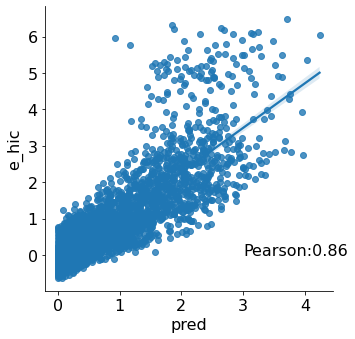

<Figure size 800x640 with 0 Axes>

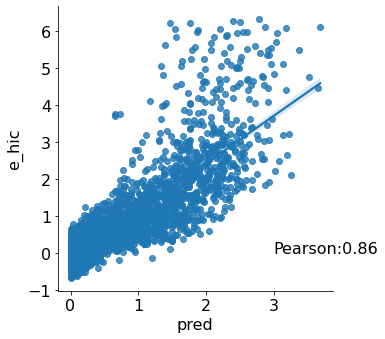

<Figure size 800x640 with 0 Axes>

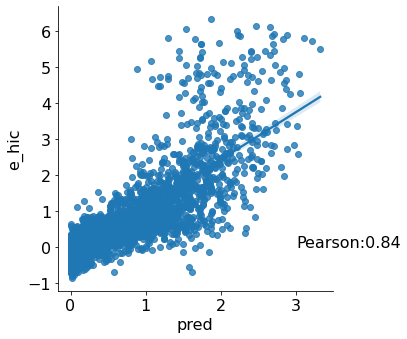

<Figure size 800x640 with 0 Axes>

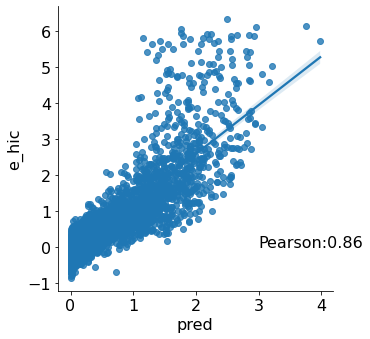

<Figure size 800x640 with 0 Axes>

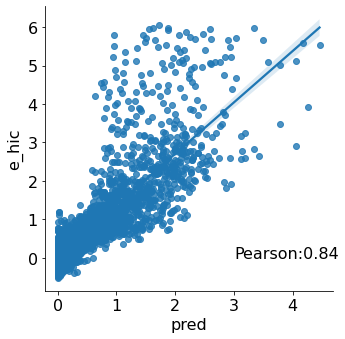

<Figure size 800x640 with 0 Axes>

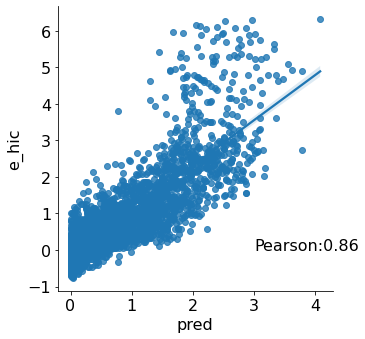

<Figure size 800x640 with 0 Axes>

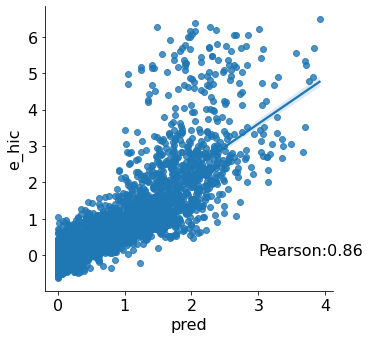

<Figure size 800x640 with 0 Axes>

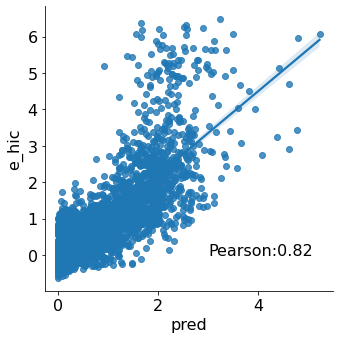

<Figure size 800x640 with 0 Axes>

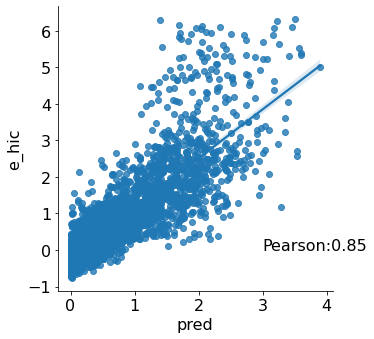

<Figure size 800x640 with 0 Axes>

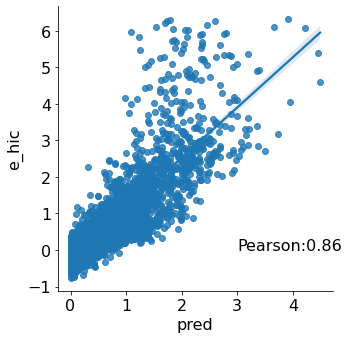

In [132]:
ndata1 = pandas.read_csv("data/V_chr" + str(chrom) + ".csv")
ndata1.v_start = ndata1.v_start * chr_len[chrom]
ndata1.v_end = ndata1.v_end * chr_len[chrom]
ndata1.v_start = ndata1.v_start.astype(int)
ndata1.v_end = ndata1.v_end.astype(int)

edata_pred_all = pandas.DataFrame()
for data in test_loader:
    pos0 = ndata.v_index[(ndata.v_start <= data.x[0,0].numpy()) & (ndata.v_end >= data.x[0,0].numpy())]
    pos0 = pos0.values[0]
    edge_index = np.vstack((np.arange(128).repeat(128),np.tile(np.arange(128),128)))
    edge_index = edge_index[:,edge_index[0] <= edge_index[1]]
    data.edge_index = edge_index
    data.to(device)
    z = model.encode(data.x, data.edge_index, data.batch) #encoding output
    pred = model.decoder(z, data.edge_index, sigmoid=False) 
    pred = pred.cpu().detach()
    pred_df = pd.DataFrame(data.edge_index.T + pos0)
    pred_df[3] = pred.numpy()
    pred_df.columns = ['e_from','e_to','pred_hic']
    #pred_df = pd.merge(pred_df, edata, on = ['e_from','e_to'], how = 'left')
    edata_pred = pred_df
    v1 = edata_pred[['e_from']]
    v1.columns = ['v_index']
    v1 = pandas.merge(v1, ndata1[['v_index',"v_start",'v_end']], on= "v_index", how="left")
    v2 = edata_pred[['e_to','pred_hic']]
    v2.columns = ['v_index','pred']
    v2 = pandas.merge(ndata1[['v_index',"v_start",'v_end']],v2, on= "v_index", how="right")
    edata_pred = pandas.concat([v1,v2], axis=1)
    edata_pred.columns = ['e_from',"v_start1",'v_end1','e_to',"v_start2",'v_end2','pred']
    edata_pred = pandas.merge(edata_pred, edata[['e_from','e_to','e_hic']])
    plt.figure(figsize=(10, 8), dpi=80)
    fig1 = sns.lmplot(x = 'pred', y = 'e_hic', data = edata_pred)
    plt.text(3,0,"Pearson:{:.2f}".format(edata_pred[['pred','e_hic']].corr().iloc[1,0]))
    plt.axis('on')
    edata_pred_all = pandas.concat([edata_pred_all, edata_pred], axis=0)
# edata_pred_all.to_csv(outpath+'/pred.csv',index=None)

In [124]:
edata_pred_all

,e_from,v_start1,v_end1,e_to,v_start2,v_end2,pred,e_hic
0,149,12039138,12092912,149,12039138,12092912,2.653700,4.912621
1,149,12039138,12092912,150,12092912,12121394,2.334344,3.220123
2,149,12039138,12092912,151,12121394,12237382,2.383904,2.203931
3,149,12039138,12092912,152,12237382,12247090,1.837504,2.432534
4,149,12039138,12092912,153,12247090,12271785,2.368619,2.384303
...,...,...,...,...,...,...,...,...
5340,522,46777422,46941927,523,46941927,46974359,2.498616,2.846634
5341,522,46777422,46941927,524,46974359,47037204,2.390599,2.209366
5342,523,46941927,46974359,523,46941927,46974359,2.684189,5.274620
5343,523,46941927,46974359,524,46974359,47037204,2.451596,3.105351


### 1.2 Plot heatmap

mat1 is labeling derived from Hi-C data, and mat2 is the predicted interaction by Chrombus. We transformed the CTCF-based interaction to 5kb-bin based format.

In [85]:
mat1_dict={}
mat2_dict={}
pos = []
n=0
for data in test_loader:
    n+=1
    start = math.ceil(data.x[0,0] * chr_len[chrom] / 5000) * 5000
    end = int(data.x[-1,1] * chr_len[chrom] / 5000) * 5000
    pos.append([start, end])
    nrow = int((end - start) / 5000) + 1
    pos0 = ndata.v_index[(ndata.v_start <= data.x[0,0].numpy()) & (ndata.v_end >= data.x[0,0].numpy())]
    pos0 = pos0.values[0]
    pos1 = pos0+128

    raw_edge_index = data.edge_index
    edge_index = np.vstack((np.arange(128).repeat(128),np.tile(np.arange(128),128)))
    edge_index = edge_index[:,edge_index[0] <= edge_index[1]]
    data.edge_index = edge_index
    data.to(device)
    z = model.encode(data.x, data.edge_index, data.batch) #encoding output
    pred = model.decoder(z, data.edge_index, sigmoid=False)
    pred = pred.cpu().detach()
    
    #
    start = math.ceil(data.x[0,0] * chr_len[chrom] / 5000) * 5000
    end = int(data.x[-1,1] * chr_len[chrom] / 5000) * 5000
    [start, end]
    nrow = int((end - start) / 5000) + 1
    init_value0 = np.nan
    #
    #mat1
    edata_temp = edata[(edata.e_from >= pos0) & (edata.e_from <= pos1) & (edata.e_to >= pos0) & (edata.e_to <= pos1)]
    mat1 = np.array([init_value0] * nrow * nrow).reshape([nrow, nrow])
    for i, row in edata_temp.iterrows():
        x1 = int((row[3] * chr_len[chrom] - start) / 5000)
        x2 = int((row[4] * chr_len[chrom] - start) / 5000)
        y1 = int((row[5] * chr_len[chrom] - start) / 5000)
        y2 = int((row[6] * chr_len[chrom] - start) / 5000)
        if x1 < 0:
            x1 = 0
        if y1 < 0:
            y1 = 0
        if x2 > nrow:
            x2 = nrow
        if y2 > nrow:
            y2 = nrow
        mat1[x1:x2, y1:y2] = row[2]
        mat1[y1:y2, x1:x2] = row[2]
    mat1_dict[n] = mat1
    #
    mat2 = np.array([init_value0] * nrow * nrow).reshape([nrow, nrow])
    for i in range(edge_index.shape[1]):
        x1 = int((data.x[data.edge_index[0,i],0] * chr_len[chrom] - start) / 5000)
        x2 = int((data.x[data.edge_index[0,i],1] * chr_len[chrom] - start) / 5000)
        y1 = int((data.x[data.edge_index[1,i],0] * chr_len[chrom] - start) / 5000)
        y2 = int((data.x[data.edge_index[1,i],1] * chr_len[chrom] - start) / 5000)
        if x1 < 0:
            x1 = 0
        if y1 < 0:
            y1 = 0
        if x2 > nrow:
            x2 = nrow
        if y2 > nrow:
            y2 = nrow
        mat2[x1:x2, y1:y2] = pred[i]
        mat2[y1:y2, x1:x2] = pred[i]
        mat2_dict[n] = mat2
    
    


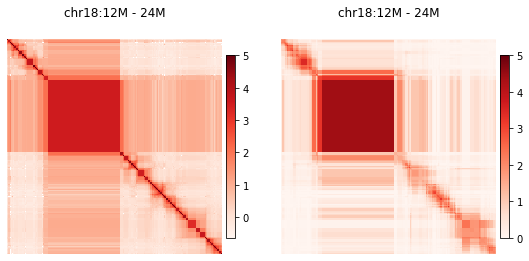

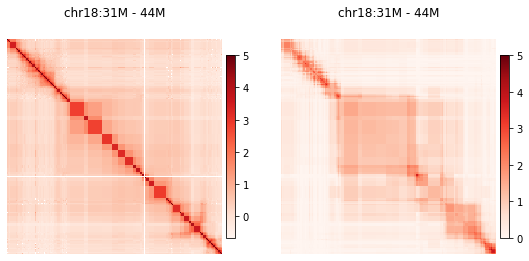

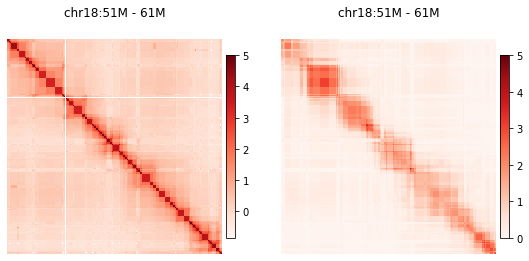

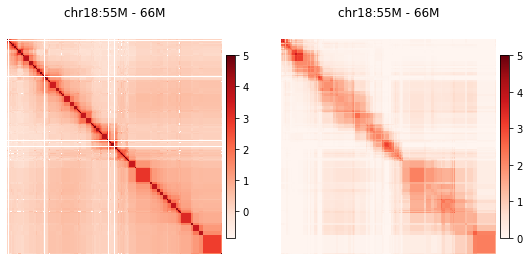

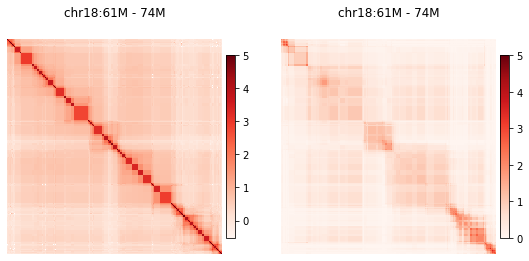

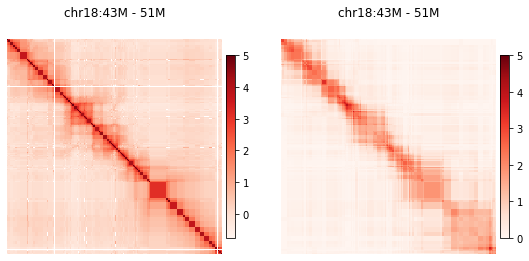

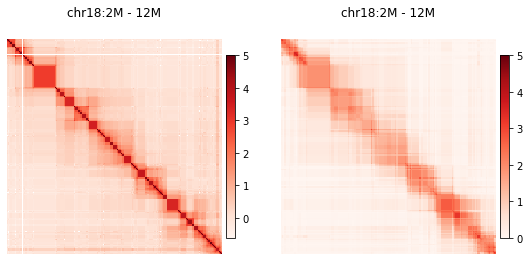

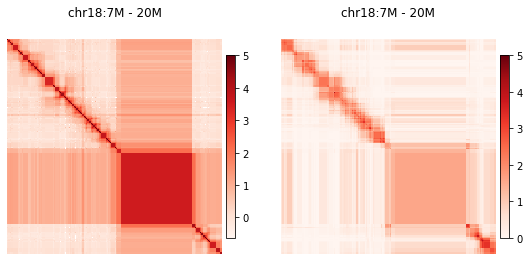

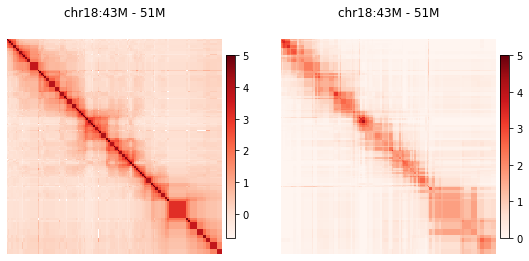

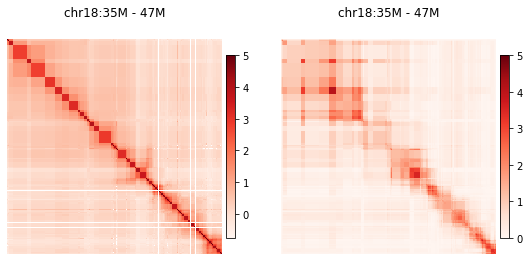

In [86]:
for n in mat1_dict.keys():
    plt.figure(figsize=(9,4))
    plt.subplot(121) 
    im = plt.matshow(mat1_dict[n], fignum=False, vmax = 5, cmap = 'Reds')
    plt.colorbar(im, fraction=.04, pad = 0.02)
    plt.axis('off')
    plt.title("chr"+str(chrom)+":"+str(int(pos[n-1][0]/1e6))+"M - "+str(int(pos[n-1][1]/1e6))+"M")
    plt.subplot(122) 
    im = plt.matshow(mat2_dict[n], fignum=False, vmax = 5, cmap = 'Reds')
    plt.colorbar(im, fraction=.04, pad = 0.02)
    plt.axis('off')
    plt.title("chr"+str(chrom)+":"+str(int(pos[n-1][0]/1e6))+"M - "+str(int(pos[n-1][1]/1e6))+"M")

# 2. Predicting specific regions

In [173]:
chrom = 18
start = 32960000
end = 33560000
ndata = pandas.read_csv("data/V_chr" + str(chrom) + ".csv")
edata = pandas.read_csv("data/chr" + str(chrom) + "_edges.csv")
edata.columns = ['e_from','e_to','e_hic','g1.v_start','g1.v_end','g2.v_start','g2.v_end']

In [174]:
idx0 = ndata[(ndata.v_start * chr_len[chrom] <= start) & (ndata.v_end * chr_len[chrom] >= start)].v_index.values[0]
idx1 = ndata[(ndata.v_start * chr_len[chrom] <= end) & (ndata.v_end * chr_len[chrom] >= end)].v_index.values[0]
n = int((128 - (idx1 - idx0)) / 2)
pos0 = idx0 - n
pos1 = pos0 + 128
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
ndata1 = ndata.copy()
ndata1.columns = [*range(ndata1.shape[1])]
x = ndata1[pos0:pos1]
x = torch.tensor(x[[*range(2,16)]].values, dtype=torch.float)
data = next(iter(test_loader))
data.x = x
data.to(device)
#
edge_index = np.vstack((np.arange(128).repeat(128),np.tile(np.arange(128),128)))
edge_index = edge_index[:,edge_index[0] <= edge_index[1]]
data.edge_index = edge_index
data.to(device)
z = model.encode(data.x, data.edge_index, data.batch) #encoding output
pred = model.decoder(z, data.edge_index, sigmoid=False) 
pred = pred.cpu().detach()
pred_df = pd.DataFrame(data.edge_index.T + pos0)
pred_df[3] = pred.numpy()
# pred_out = pd.concat([pred_out, pred_df])
# test_pred_dict[pos0] = pred_df
pred_df.columns = ['e_from','e_to','pred_hic']
pred_df = pd.merge(pred_df, edata.iloc[:,:3], on = ['e_from','e_to'], how = 'left')
ndata.v_start = ndata.v_start * chr_len[chrom]
ndata.v_start = ndata.v_start.astype(int)
ndata.v_end = ndata.v_end * chr_len[chrom]
ndata.v_end = ndata.v_end.astype(int)
temp = ndata.iloc[:,[0,2,3]].copy()
temp.rename(columns = {"v_index":"e_from"}, inplace = True)
pred_df = pd.merge(pred_df, temp, on = ['e_from'], how = 'left',suffixes= ["","0"])
temp = ndata.iloc[:,[0,2,3]].copy()
temp.rename(columns = {"v_index":"e_to"}, inplace = True)
pred_df = pd.merge(pred_df, temp, on = ['e_to'], how = 'left',suffixes= ["","1"])
#pred_df.to_csv(outpath +'/chr'+str(chrom)+ ":" + str(start) + "-" + str(end) +'_pred.ctcf.csv',index=False)


In [175]:
pred_df

,e_from,e_to,pred_hic,e_hic,v_start,v_end,v_start1,v_end1
0,296,296,1.548086,3.121376,27956686,28470054,27956686,28470054
1,296,297,1.819737,1.714080,27956686,28470054,28470054,28551537
2,296,298,1.672979,1.020737,27956686,28470054,28551537,28786886
3,296,299,1.351143,0.626552,27956686,28470054,28786886,28822122
4,296,300,1.684019,0.750498,27956686,28470054,28822122,28846641
...,...,...,...,...,...,...,...,...
8251,421,422,1.277828,1.489794,40176349,40851990,40851990,40976414
8252,421,423,0.952911,1.265698,40176349,40851990,40976414,41001084
8253,422,422,1.472250,4.159254,40851990,40976414,40851990,40976414
8254,422,423,1.206903,2.657882,40851990,40976414,40976414,41001084


(-0.2004539012883506,
 4.209531927108643,
 -0.8862669370222407,
 6.591939483464928)

<Figure size 800x640 with 0 Axes>

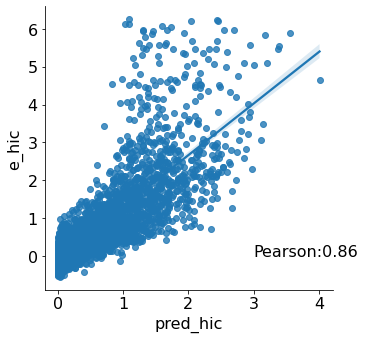

In [176]:
plt.figure(figsize=(10, 8), dpi=80)
fig1 = sns.lmplot(x = 'pred_hic', y = 'e_hic', data = pred_df)
plt.text(3,0,"Pearson:{:.2f}".format(edata_pred[['pred','e_hic']].corr().iloc[1,0]))
plt.axis('on')

In [177]:
chrom = 18
start = 154395000
end = 55230000
ndata = pandas.read_csv("data/V_chr" + str(chrom) + ".csv")
edata = pandas.read_csv("data/chr" + str(chrom) + "_edges.csv")
edata.columns = ['e_from','e_to','e_hic','g1.v_start','g1.v_end','g2.v_start','g2.v_end']
#mat1
start = math.ceil(ndata['v_start'].values[pos0] * chr_len[chrom] / 5000) * 5000
end = int(ndata['v_end'].values[pos1] * chr_len[chrom] / 5000) * 5000
nrow = int((end - start) / 5000) + 1
mat1 = np.array([init_value0] * nrow * nrow).reshape([nrow, nrow])
mat2 = np.array([init_value0] * nrow * nrow).reshape([nrow, nrow])
for i, row in pred_df.iterrows():
    x1 = int((row[4] - start) / 5000)
    x2 = int((row[5] - start) / 5000)
    y1 = int((row[6] - start) / 5000)
    y2 = int((row[7] - start) / 5000)
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > nrow:
        x2 = nrow
    if y2 > nrow:
        y2 = nrow
    mat2[x1:x2, y1:y2] = row[2]
    mat2[y1:y2, x1:x2] = row[2]
    mat1[x1:x2, y1:y2] = row[3]
    mat1[y1:y2, x1:x2] = row[3]

Text(0.5, 1.0, 'chr18:27M - 28M')

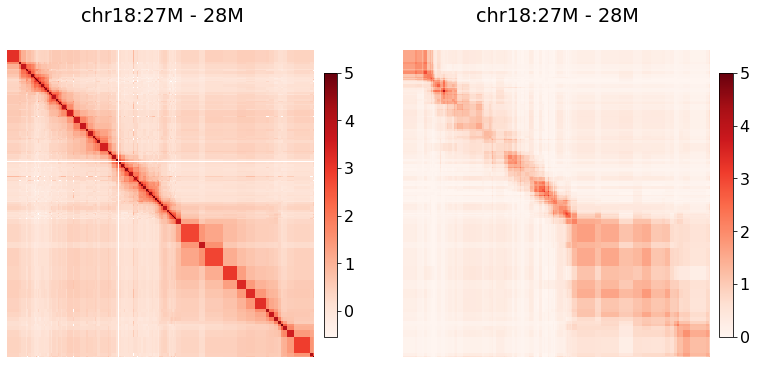

In [178]:
plt.figure(figsize=(13,6))
plt.subplot(121) 
im = plt.matshow(mat1, fignum=False, vmax = 5, cmap = 'Reds')
plt.colorbar(im, fraction=.04, pad = 0.02)
plt.axis('off')
plt.title("chr"+str(chrom)+":"+str(int(pred_df.v_start.values[0]/1e6))+"M - "+str(int(pred_df.v_end.values[0]/1e6))+"M")
plt.subplot(122) 
im = plt.matshow(mat2, fignum=False, vmax = 5, cmap = 'Reds')
plt.colorbar(im, fraction=.04, pad = 0.02)
plt.axis('off')
plt.title("chr"+str(chrom)+":"+str(int(pred_df.v_start.values[0]/1e6))+"M - "+str(int(pred_df.v_end.values[0]/1e6))+"M")
# plt.close()